Install the necessary packages

In [ ]:
!pip install keras-segmentation

Download the dataset witch is going to be used in the training of model.

In [ ]:
! wget https://github.com/divamgupta/datasets/releases/download/seg/dataset1.zip && unzip dataset1.zip

Import necessary packages

In [ ]:
from keras_segmentation.models.mobilenet import get_mobilenet_encoder
from tensorflow.keras import layers,Input,Model
from tensorflow.keras.layers import Conv2D,Dropout,MaxPooling2D,concatenate,UpSampling2D
from numpy import reshape
from keras.layers import Reshape,Activation
from types import MethodType
from keras_segmentation.train import train
from keras_segmentation.models.config import  IMAGE_ORDERING
from keras_segmentation.predict import predict, predict_multiple, evaluate
from keras_segmentation.models.model_utils import get_segmentation_model
from keras_segmentation.models.unet import IMAGE_ORDERING,MERGE_AXIS
from tensorflow.keras.layers import ZeroPadding2D,BatchNormalization

**Mobilnet as encoder download pretrained model on Imagenet dataset**

In [ ]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import get_file

BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/'
                    'releases/download/v0.6/')


def relu6(x):
    return K.relu(x, max_value=6)


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):

    channel_axis = 1 if IMAGE_ORDERING == 'channels_first' else -1
    filters = int(filters * alpha)
    x = ZeroPadding2D(padding=(1, 1), name='conv1_pad',
                      data_format=IMAGE_ORDERING)(inputs)
    x = Conv2D(filters, kernel, data_format=IMAGE_ORDERING,
               padding='valid',
               use_bias=False,
               strides=strides,
               name='conv1')(x)
    x = BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return Activation(relu6, name='conv1_relu')(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):

    channel_axis = 1 if IMAGE_ORDERING == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING,
                      name='conv_pad_%d' % block_id)(inputs)
    x = DepthwiseConv2D((3, 3), data_format=IMAGE_ORDERING,
                        padding='valid',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(x)
    x = BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1), data_format=IMAGE_ORDERING,
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=channel_axis,
                           name='conv_pw_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)


def get_mobilenet_encoder(input_height=224, input_width=224,
                          pretrained='imagenet'):

    # todo add more alpha and stuff

    assert (K.image_data_format() ==
            'channels_last'), "Currently only channels last mode is supported"
    assert (IMAGE_ORDERING ==
            'channels_last'), "Currently only channels last mode is supported"
    assert (input_height == 224), \
        "For mobilenet , 224 input_height is supported "
    assert (input_width == 224), "For mobilenet , 224 width is supported "

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    alpha = 1.0
    depth_multiplier = 1
    dropout = 1e-3

    img_input = Input(shape=(input_height, input_width, 3))

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)
    f1 = x

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)
    f2 = x

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)
    f3 = x

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
    f4 = x

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)
    f5 = x

    if pretrained == 'imagenet':
        model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)

        weight_path = BASE_WEIGHT_PATH + model_name
        weights_path = tf.keras.utils.get_file(model_name, weight_path)

        Model(img_input, x).load_weights(weights_path)

    return img_input, [f1, f2, f3, f4, f5]


**Unet model as decoder**

In [ ]:
def unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608, channels=3):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width)
    [f1, f2, f3, f4, f5] = levels

    o = f4

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f3], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f2], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(128, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)

    if l1_skip_conn:
        o = (concatenate([o, f1], axis=MERGE_AXIS))

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', activation='relu', data_format=IMAGE_ORDERING, name="seg_feats"))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same',
               data_format=IMAGE_ORDERING)(o)

    model = get_segmentation_model(img_input, o)

    return model

**Implementation of model in which mobilenet as encoder and Unet as decoder.**

In [ ]:
def mobilenet_unet(n_classes, input_height=224, input_width=224,
                   encoder_level=3, channels=3):

    model = unet(n_classes, get_mobilenet_encoder,
                  input_height=input_height, input_width=input_width, channels=channels)
    model.model_name = "mobilenet_unet"
    return model

calling a model

In [ ]:
model=mobilenet_unet(n_classes=51,input_height=224,input_width=224)

Saving assets of model

In [ ]:
model.save('/content/mobilenetunet')

INFO:tensorflow:Assets written to: /content/mobilenetunet/assets


In [ ]:
import os
os.mkdir('/content/Test_Images')
os.mkdir('/content/Output_Images')
os.mkdir('/content/checkpoint/mobilenet')

**Train model on custome dataset**

In [ ]:
model.train(
    train_images =  "dataset1/images_prepped_train/",
    train_annotations = "dataset1/annotations_prepped_train/",
    checkpoints_path = "/content/checkpoint/mobilenetunet" , epochs=10  
)

  4%|▍         | 16/367 [00:00<00:02, 156.50it/s]

Verifying training dataset


100%|██████████| 367/367 [00:02<00:00, 180.38it/s]
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 66s 43ms/step - loss: 3.8969 - accuracy: 0.1246
saved  /content/mobilenetunet.0
Epoch 2/10
512/512 [==============================] - 22s 42ms/step - loss: 2.0609 - accuracy: 0.6092
saved  /content/mobilenetunet.1
Epoch 3/10
512/512 [==============================] - 22s 42ms/step - loss: 1.4531 - accuracy: 0.7243
saved  /content/mobilenetunet.2
Epoch 4/10
512/512 [==============================] - 22s 42ms/step - loss: 1.1987 - accuracy: 0.7605
saved  /content/mobilenetunet.3
Epoch 5/10
512/512 [==============================] - 22s 42ms/step - loss: 1.0612 - accuracy: 0.7788
saved  /content/mobilenetunet.4
Epoch 6/10
512/512 [==============================] - 22s 42ms/step - loss: 0.9644 - accuracy: 0.7926
saved  /content/mobilenetunet.5
Epoch 7/10
512/512 [==============================] - 22s 42ms/step - loss: 0.9031 - accuracy: 0.7998
saved  /content/mobilenetunet.6
Epoch 8/10
512/512 [=======================

**Predict segmentation for sample image**

In [ ]:
o = model.predict_segmentation(
    inp="/content/Test_Images/test7.jpg",
    out_fname="/content/Output_Images/out.png" , overlay_img=True
)

Display an output segmented image

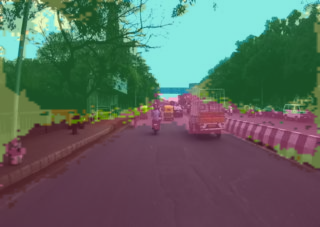

In [ ]:
 from IPython.display import Image
Image('/content/Output_Images/out.png')